Install Packages

In [ ]:
pip install sodapy

In [ ]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install mlxtend --upgrade

In [ ]:
import pandas as pd
from sodapy import Socrata

Violations Datasets

In [ ]:
data_url='data.cityofnewyork.us'    # The Host Name for the API endpoint (the https:// part will be added automatically)
data_set='xkd2-rny5'    # The data set at the API endpoint (HPD data in this case)
app_token='vOHwCjVz6ns5GhiSkjUwqQUCa'   # The app token created in the prior steps
client = Socrata(data_url,app_token)      # Create the client to point to the API endpoint
# Set the timeout to 60 seconds    
client.timeout = 180
# Retrieve the first 2000 results returned as JSON object from the API
# The SoDaPy library converts this JSON object to a Python list of dictionaries
results = client.get(data_set, limit=200000)
# Convert the list of dictionaries to a Pandas data frame
violations_df = pd.DataFrame.from_records(results)
pd.set_option('display.max_columns', None)

In [ ]:
import re as re
import numpy as np
violations_df["story"] = violations_df["story"].astype(str).dropna()  
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)
violations_df["story"] = violations_df["story"].apply(lambda x: find_number(x))
violations_df["story"].replace('', np.nan, inplace=True)
violations_df.dropna(subset=['story'], inplace=True)

In [ ]:
violations_df["boro"] = violations_df["boro"].astype(str).dropna()
violations_df["class"] = violations_df["class"].astype(str).dropna()   
violations_df["story"] = violations_df["story"].astype(int)   
violations_df["bin"] = violations_df["bin"].astype(str).dropna()   

In [ ]:
violations_df = violations_df[violations_df.bin != "nan"]

In [ ]:
# Must fix datatypes of columsn because they are strings
colNames = violations_df.columns
for i in colNames:
  print(i, "\n", type(violations_df[i][0]), "\n")

# Returns a list of columns and the number of missing values per column
violations_df.isnull().sum()

# Data cleaning on HPD Dataset (by Christian)

# The line of code below will get us 
# (Number of rows) x (Number of colums)
# We will print this line periodically in the cells for QA purposes
# How to get the number of columns of a dataframe in Python: 
# https://note.nkmk.me/en/python-pandas-len-shape-size/#:~:text=source%3A%20pandas_len_shape_size.py-,Get%20the%20number%20of%20columns%3A%20len(df.columns),()%20to%20the%20columns%20attribute.

print(len(violations_df), "x", len(violations_df.columns))

violations_df.head()
# Data Profiling: 
# Check to see which columns in the dataset have null values
# any number larger than 1 will cause the value to be "True"

violations_df.isna().any()

# Data Profiling 2
# Get the number of rows with null values
# for each column in the dataframe
violations_df.isna().sum()
# Since we will later merge the HPD Violations dataset and the DOB Boilers dataset
# on the column BIN (Building Identification Number), we will be unable to 
# use rows in the HPD Dataset where the row value in the BIN column is null

# Thus, we need to all the columns that have null values for the "bin" column in the HPD Dataset:
# How to all the columns that have null values for a given column 
# in Python Pandas: https://chat.openai.com/c/abce92b1-24ad-4fec-b280-336ef0acda0a

violations_df = violations_df.dropna(subset=['bin']) 
print(len(violations_df), "x", len(violations_df.columns))
violations_df.head()

# Check to make sure the number of null columns in the BIN column is 0

violations_df.isna().sum()

# From len(violations_df.columns)), we see that there are 40 total columns in the HPD Dataset
# We now wish to reduce the number of rows to only the columns we believe are 
# necessary for our analysis
# We do this by redefining our dataframe, and subsetting only the rows we want
# This reduces the number of rows in the dataframe by more than half, from 40 to 19

violations_df = violations_df[['bin', 'violationid', 'buildingid', 'streetname','apartment','nta', 'boro', 'story', 'class','zip','inspectiondate', 'approveddate','novid', 'novdescription', 'novissueddate','novtype', 'currentstatus', 'currentstatusdate', 'violationstatus', 'latitude', 'longitude']]
print(len(violations_df), "x", len(violations_df.columns))
violations_df.head()
# Next we need to change the date columns (i.e. inspectiondate, approveddate, etc.) into datetime format
# In Python, dates in datetime format will ALWAYS follow the format "YYYY-MM-DD"
# We use the .apply method to do the command (pd.to_datetime) to each of the date columns
# Also we should note that the column novissueddate has 198 null rows
# To ensure we don't get errors, we also write "errors = 'coerce'" within the .apply function
# This will put the value NaT (Not a time) in the rows where the date column is empty
# ChatGPT chat used to generate code:
# https://chat.openai.com/c/8a27651c-7696-4741-91b4-df9c89da90f8

# Changing the dates in the dataframe into datetime format: 
violations_df[['inspectiondate', 'approveddate', 'novissueddate', 'currentstatusdate']] = violations_df[['inspectiondate', 'approveddate', 'novissueddate', 'currentstatusdate']].apply(pd.to_datetime, errors= 'coerce')

# Previous failed code:
# Note: Changing the date values into "DD-MM-YYYY" format will yield row values that in "text/string" format rather than datetime!!!!!
# hpd_dataset_sub1[['inspectiondate', 'approveddate', 'novissueddate', 'currentstatusdate']] = hpd_dataset_sub1[['inspectiondate', 'approveddate', 'novissueddate', 'currentstatusdate']].apply(lambda x: x.dt.strftime('%m/%d/%Y'))
# This will keep the value as a string. Dates in datetime format must be in YYYY-MM-DD format!

print(len(violations_df), "x", len(violations_df.columns))
violations_df.head()

Aggregated Voilations Dataset

In [ ]:
num_violations = violations_df.groupby(['bin', 'boro', 'story', 'class']).size().reset_index(name='violations_count') 
num_violations

,bin,boro,story,class,violations_count
0,1000000,MANHATTAN,1,C,4
1,1000000,MANHATTAN,2,C,4
2,1000000,MANHATTAN,3,C,10
3,1000000,MANHATTAN,4,B,1
4,1000000,MANHATTAN,4,C,6
...,...,...,...,...,...
63439,5169985,STATEN ISLAND,1,C,3
63440,5170597,STATEN ISLAND,2,C,1
63441,5170869,STATEN ISLAND,1,C,1
63442,5171114,STATEN ISLAND,2,C,3


Boiler Dataset

In [ ]:
import pandas as pd
from sodapy import Socrata

data_url_2='data.cityofnewyork.us'    # The Host Name for the API endpoint (the https:// part will be added automatically)
data_set_2='52dp-yji6'    # The data set at the API endpoint (HPD data in this case)
app_token='vOHwCjVz6ns5GhiSkjUwqQUCa'   # The app token created in the prior steps
client_2 = Socrata(data_url_2,app_token)      # Create the client to point to the API endpoint
# Set the timeout to 60 seconds    
client_2.timeout = 240
# Retrieve the first 2000 results returned as JSON object from the API
# The SoDaPy library converts this JSON object to a Python list of dictionaries
results_2 = client_2.get(data_set_2, limit=500000)
# Convert the list of dictionaries to a Pandas data frame
boilers_df = pd.DataFrame.from_records(results_2)
pd.set_option('display.max_columns', None)

# Check the number of rows and columns in the dataframe
print(len(boilers_df), "x", len(boilers_df.columns))
boilers_df.head()

500000 x 21


,tracking_number,boiler_id,report_type,pressure_type,inspection_date,defects_exist,lff_45_days,lff_180_days,filing_fee,total_amount_paid,report_status,bin_number,boiler_make,boiler_model,inspection_type,applicantfirst_name,applicant_last_name,applicant_license_type,applicant_license_number,owner_first_name,owner_last_name
0,2016-30000154324Y0001-71268,30000154324Y0001,Subsequent,Low Pressure,02/19/2017 00:00:00,No,0,0,30,0,Accepted,3079366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-10000010591Y0001-018,10000010591Y0001,Initial,Low Pressure,05/19/2017 00:00:00,No,0,0,30,0,Accepted,1063482,FEDERAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-10000823916N0001-6255,10000823916N0001,Initial,Low Pressure,06/21/2017 00:00:00,Yes,0,0,30,0,Accepted,1038485,WEILMCLAIN,CGA-6 SPDN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-10000919714Y0001-6499,10000919714Y0001,Initial,Low Pressure,05/24/2017 00:00:00,No,0,0,30,0,Accepted,1057945,WEILMCLAIN,LGB-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-20000003110Y0001-1309,20000003110Y0001,Initial,Low Pressure,03/28/2017 00:00:00,Yes,0,0,30,0,Accepted,2008438,FEDERAL,MP100,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
unilux_list = ["UNILUX"]
hamilton_list = ["HAMILTON"]
utica_list = ["UTICA"]
columbia_list = ["COLUMBIA"]
pacific_list = ["PACIFIC"]
aerco_list = ["AERCO"]
laar_list = ["LAAR"]
rbi_list = ["RBI"]
weilmclain_list = ["WEIL", "MCLAIN", "WMCL", "WEIL MCLAIN"]
burnham_list = ["BURN"]
peerless_list = ["PEER", "LESS"]
hydrotherm_list = ["HYDRO", "THERM"]
usnational_list = ["US NATIONAL", "USNATIONAL", "NATIONAL US", "NATIONALUS"]
usradiator_list = ["US RADIATOR", "USRADIATOR", "RADIATOR US", "RADIATORUS"]
rockmills_list = ["ROCKMILLS", "ROCKMIL", "ROCKMILLS STEEL", "ROCKMILLS STE"]
kewanee_list = ["KEWANEE", "KEWANEE BOILER MANUF"]
cleaverbrooks_list = ["CLEAVER", "BROOK"]
veissman_list = ["VEIS"]
hbsmith_list = ["HB SMITH","HBSMITH","SMITH HB", "SMITHHB"]
aosmith_list = ["AO SMITH","AOSMITH", "SMITH AO","SMITHAO"]
slantfin_list = ["SLANT FIN", "SLANTFIN", "SLANT", "SLANT/FIN"]
fulton_list = ["FULTON"]
lochinvar_list = ["LOCHINVAR"]
dunkirk_list = ["DUNKIRK"]
federal_list = ["FEDERAL"]
raypak_list = ["RAYPAK"]
newyorker_list = ["NEW YORKER"]


## Dictionary!
## building a dict from most frequent (> 500) boiler make entries

boilermake_dict = {}

for i in slantfin_list:
  boilermake_dict[i] = "SLANTFIN"

for i in lochinvar_list:
  boilermake_dict[i] = "LOCHINVAR"

for i in raypak_list:
  boilermake_dict[i] = "RAYPAK"

for i in newyorker_list:
  boilermake_dict[i] = "NEW YORKER"

for i in dunkirk_list:
  boilermake_dict[i] = "DUNKIRK"

for i in rbi_list:
  boilermake_dict[i] = "RBI"

for i in federal_list:
  boilermake_dict[i] = "FEDERAL"

for i in fulton_list:
  boilermake_dict[i] = "FULTON"

for i in unilux_list:
  boilermake_dict[i] = "UNILUX"

for i in hamilton_list:
  boilermake_dict[i] = "HAMILTON"

for i in utica_list:
  boilermake_dict[i] = "UTICA"

for i in columbia_list:
  boilermake_dict[i] = "COLUMBIA"

for i in pacific_list:
  boilermake_dict[i] = "PACIFIC"

for i in aerco_list:
  boilermake_dict[i] = "AERCO"

for i in laar_list:
  boilermake_dict[i] = "LAAR"

for i in weilmclain_list:
  boilermake_dict[i] = "WEIL MCLAIN"

for i in burnham_list:
  boilermake_dict[i] = "BURN"

for i in peerless_list:
  boilermake_dict[i] = "PEERLESS"

for i in hydrotherm_list:
  boilermake_dict[i] = "HYDROTHERM"

for i in usnational_list:
  boilermake_dict[i] = "US NATIONAL"

for i in usradiator_list:
  boilermake_dict[i] = "US RADIATOR"

for i in rockmills_list:
  boilermake_dict[i] = "ROCKMILLS"

for i in kewanee_list:
  boilermake_dict[i] = "KEWANEE"

for i in cleaverbrooks_list:
  boilermake_dict[i] = "CLEAVERBROOKS"

for i in veissman_list:
  boilermake_dict[i] = "VEISSMAN"

for i in hbsmith_list:
  boilermake_dict[i] = "HB SMITH"

for i in aosmith_list:
  boilermake_dict[i] = "AO SMITH"


## Dict Keys    - will serve as a list of tokens

boilermake_tokens = list(boilermake_dict.keys())

Boiler Make

In [ ]:
boilers_df["boiler_make"] = boilers_df["boiler_make"].astype(str).dropna()      # Applying astype function
all(isinstance(x, str) for x in boilers_df["boiler_make"])  ## not all entries are strings

boilers_df.head()

,tracking_number,boiler_id,report_type,pressure_type,inspection_date,defects_exist,lff_45_days,lff_180_days,filing_fee,total_amount_paid,report_status,bin_number,boiler_make,boiler_model,inspection_type,applicantfirst_name,applicant_last_name,applicant_license_type,applicant_license_number,owner_first_name,owner_last_name
0,2016-30000154324Y0001-71268,30000154324Y0001,Subsequent,Low Pressure,02/19/2017 00:00:00,No,0,0,30,0,Accepted,3079366,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-10000010591Y0001-018,10000010591Y0001,Initial,Low Pressure,05/19/2017 00:00:00,No,0,0,30,0,Accepted,1063482,FEDERAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-10000823916N0001-6255,10000823916N0001,Initial,Low Pressure,06/21/2017 00:00:00,Yes,0,0,30,0,Accepted,1038485,WEILMCLAIN,CGA-6 SPDN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-10000919714Y0001-6499,10000919714Y0001,Initial,Low Pressure,05/24/2017 00:00:00,No,0,0,30,0,Accepted,1057945,WEILMCLAIN,LGB-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-20000003110Y0001-1309,20000003110Y0001,Initial,Low Pressure,03/28/2017 00:00:00,Yes,0,0,30,0,Accepted,2008438,FEDERAL,MP100,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Proportionate sample of boilers (~ 70 records)
proportionate_sample = boilers_df.groupby('boiler_make', group_keys=False).apply(lambda x: x.sample(frac=0.00015))
## Testing replacement function with closest match
import difflib

# list of tokens: boilermake_tokens
# test dataset: proportionate_sample
# dictionary: boilermake_dict


n=1                  # n=1 because we want to select the best match (if any)
cutoff = 0.75         # Cutoff at .75 ensures that function doesn't transforms makes that are not in the dictionary and do not need to be transformed

# stackoverflow: https://stackoverflow.com/questions/69781955/python-pandas-substitute-all-elements-in-a-dataframe-column-with-closest-string 
## goal: match input make records (boiler_make) to the best match from make tokens (make_token), then match the tokens to the correct boiler make names (correct_make)

proportionate_sample["make_token"] = [next(iter(difflib.get_close_matches(name, boilermake_tokens, n, cutoff)), name) for name in proportionate_sample["boiler_make"]]
proportionate_sample["correct_make"] = [boilermake_dict[name] if name in boilermake_tokens else name for name in proportionate_sample["make_token"]]

proportionate_sample


,tracking_number,boiler_id,report_type,pressure_type,inspection_date,defects_exist,lff_45_days,lff_180_days,filing_fee,total_amount_paid,report_status,bin_number,boiler_make,boiler_model,inspection_type,applicantfirst_name,applicant_last_name,applicant_license_type,applicant_license_number,owner_first_name,owner_last_name,make_token,correct_make
308520,2020-30000202794Y0001-297436,30000202794Y0001,Initial,Low Pressure,08/28/2020 00:00:00,No,0,0,30,30,Accepted,3422112,AERCO,BMK6000,External,RICHARD,MORTMAN,O,2633,DULCE,HAUGHTON,AERCO,AERCO
10987,2017-10000160218Y0001-6660,10000160218Y0001,Initial,Low Pressure,08/09/2017 00:00:00,No,0,0,30,30,Accepted,1087987,AO SMITH,HW-520,External,BRIAN,SEIBERT,BB,5492,AARON,HOFFMAN,AO SMITH,AO SMITH
375279,2021-20000201641N0006-395653,20000201641N0006,Initial,Low Pressure,08/05/2021 00:00:00,No,0,0,30,0,Pre-filing,2003843,BEST,5B-125,External,JOHN,KNIEF,O,5317,ROBERT,KNIEF,BEST,BEST
467544,2022-20000102388N0001-498409,20000102388N0001,Initial,Low Pressure,09/07/2022 00:00:00,No,0,0,30,30,Accepted,2018100,BURNHAM,OTHER,External,ANDREW,BOYER,BB,5564,SHERYL,HARDING,BURNHAM,BURNHAM
135102,2018-40000158714Y0001-75947,40000158714Y0001,Initial,Low Pressure,04/27/2018 00:00:00,No,0,0,30,30,Accepted,4004794,BURNHAM,V908,External,RADOMIR,RADOMIR,BB,5441,LARRY,VAFEAS,BURNHAM,BURNHAM
91815,2018-30000030240Y0001-131390,30000030240Y0001,Initial,Low Pressure,11/19/2018 00:00:00,No,0,0,30,30,Accepted,3121212,BURNHAM,KIN11LNI-LL2,External,CHARLES,WILSON,BB,5568,JUD,BENJAMIN,BURNHAM,BURNHAM
111033,2018-30000154680Y0001-131730,30000154680Y0001,Initial,Low Pressure,11/13/2018 00:00:00,No,0,0,30,30,Accepted,3056647,BURNHAM,5012,External,RICHARD C.,WEST,O,4266,JUDY,SCHWIMMER,BURNHAM,BURNHAM
205516,2019-30000113250N0001-229404,30000113250N0001,Initial,Low Pressure,12/04/2019 00:00:00,Yes,0,0,30,30,Accepted,3096697,BURNHAM,IN-11,External,HENRY,TRAKTMAN,P,1341,JOSEPH,ORTIZ,BURNHAM,BURNHAM
93848,2018-30000038085Y0001-133997,30000038085Y0001,Initial,Low Pressure,12/17/2018 00:00:00,No,0,0,30,30,Accepted,3014967,BURNHAM,IN 8,External,NICHOLAS,ROSEN,P,2361,SANDRA,GUEVARA,BURNHAM,BURNHAM
414960,2021-40000064215N0001-367841,40000064215N0001,Initial,Low Pressure,04/26/2021 00:00:00,No,0,0,30,30,Accepted,4200895,CROWN,KSZ150,External,DILLON,DELORME,BB,5660,AVTAR,SINGH,CROWN,CROWN


In [ ]:
#Now we do the same for the entire boiler dataset:

n=1                  # n=1 because we want to select the best match (if any)
cutoff = 0.75         # cutoff needs to be a little higher - otherwise function transforms makes that are not in the dictionary and do not need to be transformed

# stackoverflow: https://stackoverflow.com/questions/69781955/python-pandas-substitute-all-elements-in-a-dataframe-column-with-closest-string 
## goal: match input make records (boiler_make) to the best match from make tokens (make_token), then match the tokens to the correct boiler make names (correct_make)

boilers_df["make_token"] = [next(iter(difflib.get_close_matches(name, boilermake_tokens, n, cutoff)), name) for name in boilers_df["boiler_make"]]
boilers_df["correct_make"] = [boilermake_dict[name] if name in boilermake_tokens else name for name in boilers_df["make_token"]]


In [ ]:
# where correct boiler make is not defined, it is due to missing values in boiler data entries 
boilers_df[boilers_df.correct_make == "nan"].equals(boilers_df[(boilers_df.correct_make == "nan")&(boilers_df.boiler_make == "nan")])

True

In [ ]:
boilers_df = boilers_df[boilers_df.correct_make != "nan"]
boilers_df

,tracking_number,boiler_id,report_type,pressure_type,inspection_date,defects_exist,lff_45_days,lff_180_days,filing_fee,total_amount_paid,report_status,bin_number,boiler_make,boiler_model,inspection_type,applicantfirst_name,applicant_last_name,applicant_license_type,applicant_license_number,owner_first_name,owner_last_name,make_token,correct_make
1,2017-10000010591Y0001-018,10000010591Y0001,Initial,Low Pressure,05/19/2017 00:00:00,No,0,0,30,0,Accepted,1063482,FEDERAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEDERAL,FEDERAL
2,2017-10000823916N0001-6255,10000823916N0001,Initial,Low Pressure,06/21/2017 00:00:00,Yes,0,0,30,0,Accepted,1038485,WEILMCLAIN,CGA-6 SPDN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEIL MCLAIN,WEIL MCLAIN
3,2017-10000919714Y0001-6499,10000919714Y0001,Initial,Low Pressure,05/24/2017 00:00:00,No,0,0,30,0,Accepted,1057945,WEILMCLAIN,LGB-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WEIL MCLAIN,WEIL MCLAIN
4,2017-20000003110Y0001-1309,20000003110Y0001,Initial,Low Pressure,03/28/2017 00:00:00,Yes,0,0,30,0,Accepted,2008438,FEDERAL,MP100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEDERAL,FEDERAL
5,2017-20000011746Y0001-61522,20000011746Y0001,Initial,Low Pressure,07/25/2017 00:00:00,No,0,0,30,0,Accepted,2013680,BEST,MP 80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BEST,BEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2022-30000817096Y0001-537365,30000817096Y0001,Initial,Low Pressure,12/31/2022 00:00:00,No,0,0,0,0,Pre-filing,3072581,WEIL MCLAIN,NaN,External,MARVIN,WASOFF,P,868,SALVADOR,ORTIZ,WEIL MCLAIN,WEIL MCLAIN
499996,2022-30000817123N0001-494588,30000817123N0001,Initial,Low Pressure,08/18/2022 00:00:00,No,0,0,30,30,Accepted,3135576,BURNHAM,206-NI,External,JOHN,IBARRA,BB,5128,MIRIAM,RAHMAN,BURNHAM,BURNHAM
499997,2022-30000817133N0001-449931,30000817133N0001,Initial,Low Pressure,03/21/2022 00:00:00,No,0,0,30,30,Accepted,3036415,PEERLESS,63-04L,External,GREGORY,GEIER,BB,5697,PATRICIA,MOSKOW,PEERLESS,PEERLESS
499998,2022-30000817137Y0001-495459,30000817137Y0001,Initial,Low Pressure,08/15/2022 00:00:00,No,0,0,30,30,Accepted,3246959,FEDERAL,NaN,External,VINCENT,CAPUTO,O,5356,LEO,KAZ,FEDERAL,FEDERAL


Merging Datasets 

In [ ]:
boilers_df["bin"] = boilers_df["bin_number"]
boilers_reduced = boilers_df[["bin", "correct_make", "pressure_type", "defects_exist", "report_type"]]
boilers_reduced

,bin,correct_make,pressure_type,defects_exist,report_type
1,1063482,FEDERAL,Low Pressure,No,Initial
2,1038485,WEIL MCLAIN,Low Pressure,Yes,Initial
3,1057945,WEIL MCLAIN,Low Pressure,No,Initial
4,2008438,FEDERAL,Low Pressure,Yes,Initial
5,2013680,BEST,Low Pressure,No,Initial
...,...,...,...,...,...
499995,3072581,WEIL MCLAIN,Low Pressure,No,Initial
499996,3135576,BURNHAM,Low Pressure,No,Initial
499997,3036415,PEERLESS,Low Pressure,No,Initial
499998,3246959,FEDERAL,Low Pressure,No,Initial


In [ ]:
#boiler bin are not unique
boilers_reduced["bin"].value_counts()

3071219    481
3347532    215
4092120    213
1088437    204
4112321    195
          ... 
4197128      1
4097893      1
3166505      1
2010059      1
3038514      1
Name: bin, Length: 77279, dtype: int64

In [ ]:
boilers_reduced.sort_values(by='report_type', ascending=False, inplace=True)
boilers_reduced.defects_exist.dropna(inplace=True) 
boilers_reduced = boilers_reduced[boilers_reduced.report_type != "BNR"]
boilers_reduced.drop_duplicates(subset="bin", keep='first', inplace=True)

In [ ]:
boilers_reduced

,bin,correct_make,pressure_type,defects_exist,report_type
129521,4113582,HYDROTHERM,Low Pressure,No,Subsequent
225115,4030967,WEIL MCLAIN,Low Pressure,No,Subsequent
263387,1048711,HB SMITH,Low Pressure,No,Subsequent
443506,1078688,ROCKMILLS,Low Pressure,No,Subsequent
323848,4018351,FEDERAL,Low Pressure,No,Subsequent
...,...,...,...,...,...
167829,1035768,LOCHINVAR,Low Pressure,Yes,Initial
167961,1007314,LAAR,Low Pressure,No,Initial
168626,1090242,BUDERUS,Low Pressure,No,Initial
168309,1006223,HB SMITH,Low Pressure,No,Initial


In [ ]:
#unfortunately, the bin's dont match exactly, so we wont be able to preserve all records in the HPD dataset
boilers_reduced["bin"].values in violations_df["buildingid"].values

<ipython-input-22-9e3494a5ea5a>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  boilers_reduced["bin"].values in violations_df["buildingid"].values


False

Merged Datasets

In [ ]:
HPDwithBoilers=pd.merge(num_violations,boilers_reduced, on='bin', how='inner')
HPDwithBoilers

,bin,boro,story,class,violations_count,correct_make,pressure_type,defects_exist,report_type
0,1000794,MANHATTAN,6,C,1,TELEDYNE LAAR,Low Pressure,No,Initial
1,1000810,MANHATTAN,3,C,1,ROCKMILLS,Low Pressure,No,Initial
2,1001053,MANHATTAN,5,C,2,WEIL MCLAIN,Low Pressure,No,Initial
3,1001096,MANHATTAN,2,C,1,TELEDYNE,Low Pressure,No,Initial
4,1001136,MANHATTAN,2,C,1,ROCKMILLS,Low Pressure,No,Initial
...,...,...,...,...,...,...,...,...,...
31965,5158679,STATEN ISLAND,3,C,1,HYDROTHERM,Low Pressure,No,Initial
31966,5158679,STATEN ISLAND,4,C,1,HYDROTHERM,Low Pressure,No,Initial
31967,5158679,STATEN ISLAND,8,C,1,HYDROTHERM,Low Pressure,No,Initial
31968,5164260,STATEN ISLAND,2,C,1,LAAR,Low Pressure,No,Initial


In [ ]:
HPDwithBoilers.violations_count.value_counts()


violations_dict = {}
for i in np.arange(1,2):
  violations_dict[i] = "single_violation"

for i in np.arange(2,5):
  violations_dict[i] = "repeated_violations"

for i in np.arange(5,50): 
  violations_dict[i] = "persistent_violations"
                  

HPDwithBoilers["violation_frequency"] = [violations_dict[name] if name in violations_dict.keys() else name for name in HPDwithBoilers["violations_count"]]
#HPDwithBoilers.drop(columns=['violations_count'], inplace=True)

In [ ]:
HPDwithBoilers

,bin,boro,story,class,violations_count,correct_make,pressure_type,defects_exist,report_type,violation_frequency
0,1000794,MANHATTAN,6,C,1,TELEDYNE LAAR,Low Pressure,No,Initial,single_violation
1,1000810,MANHATTAN,3,C,1,ROCKMILLS,Low Pressure,No,Initial,single_violation
2,1001053,MANHATTAN,5,C,2,WEIL MCLAIN,Low Pressure,No,Initial,repeated_violations
3,1001096,MANHATTAN,2,C,1,TELEDYNE,Low Pressure,No,Initial,single_violation
4,1001136,MANHATTAN,2,C,1,ROCKMILLS,Low Pressure,No,Initial,single_violation
...,...,...,...,...,...,...,...,...,...,...
31965,5158679,STATEN ISLAND,3,C,1,HYDROTHERM,Low Pressure,No,Initial,single_violation
31966,5158679,STATEN ISLAND,4,C,1,HYDROTHERM,Low Pressure,No,Initial,single_violation
31967,5158679,STATEN ISLAND,8,C,1,HYDROTHERM,Low Pressure,No,Initial,single_violation
31968,5164260,STATEN ISLAND,2,C,1,LAAR,Low Pressure,No,Initial,single_violation


In [ ]:
HPDwithBoilers.to_csv("HPDwithBoilers.csv")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
vio_dict = {"single_violation": 0, "repeated_violations": 1, "persistent_violations": 2}
HPDwithBoilers["violation_frequency"] = [vio_dict[name] if name in vio_dict.keys() else 0 for name in HPDwithBoilers["violation_frequency"]]
HPDwithBoilers

,bin,boro,story,class,violations_count,correct_make,pressure_type,defects_exist,report_type,violation_frequency
0,1000794,MANHATTAN,6,C,1,TELEDYNE LAAR,Low Pressure,No,Initial,0
1,1000810,MANHATTAN,3,C,1,ROCKMILLS,Low Pressure,No,Initial,0
2,1001053,MANHATTAN,5,C,2,WEIL MCLAIN,Low Pressure,No,Initial,1
3,1001096,MANHATTAN,2,C,1,TELEDYNE,Low Pressure,No,Initial,0
4,1001136,MANHATTAN,2,C,1,ROCKMILLS,Low Pressure,No,Initial,0
...,...,...,...,...,...,...,...,...,...,...
31965,5158679,STATEN ISLAND,3,C,1,HYDROTHERM,Low Pressure,No,Initial,0
31966,5158679,STATEN ISLAND,4,C,1,HYDROTHERM,Low Pressure,No,Initial,0
31967,5158679,STATEN ISLAND,8,C,1,HYDROTHERM,Low Pressure,No,Initial,0
31968,5164260,STATEN ISLAND,2,C,1,LAAR,Low Pressure,No,Initial,0


In [ ]:
hpd_boiler = HPDwithBoilers.drop(['bin'], axis=1)
hpd_boiler["defects_exist"] = [1 if name == "Yes" else 0 for name in hpd_boiler["defects_exist"]]
hpd_boiler["report_type"] = [1 if name == "Subsequent" else 0 for name in hpd_boiler["report_type"]]
hpd_boiler

,boro,story,class,violations_count,correct_make,pressure_type,defects_exist,report_type,violation_frequency
0,MANHATTAN,6,C,1,TELEDYNE LAAR,Low Pressure,0,0,0
1,MANHATTAN,3,C,1,ROCKMILLS,Low Pressure,0,0,0
2,MANHATTAN,5,C,2,WEIL MCLAIN,Low Pressure,0,0,1
3,MANHATTAN,2,C,1,TELEDYNE,Low Pressure,0,0,0
4,MANHATTAN,2,C,1,ROCKMILLS,Low Pressure,0,0,0
...,...,...,...,...,...,...,...,...,...
31965,STATEN ISLAND,3,C,1,HYDROTHERM,Low Pressure,0,0,0
31966,STATEN ISLAND,4,C,1,HYDROTHERM,Low Pressure,0,0,0
31967,STATEN ISLAND,8,C,1,HYDROTHERM,Low Pressure,0,0,0
31968,STATEN ISLAND,2,C,1,LAAR,Low Pressure,0,0,0


In [ ]:
hpd_boiler_dummies = pd.get_dummies(hpd_boiler, drop_first=False)
hpd_boiler_dummies

In [ ]:
remaining_df, test_df = train_test_split(hpd_boiler_dummies, test_size=0.94, stratify=hpd_boiler_dummies.violation_frequency)
train_df, validation_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df.violation_frequency)

In [ ]:
y_train = train_df["violation_frequency"].to_numpy()
X_train = train_df.drop(columns=["violation_frequency", "violations_count"]).to_numpy()

In [ ]:
y_test = validation_df["violation_frequency"].to_numpy()
X_test = validation_df.drop(columns=["violation_frequency", "violations_count"]).to_numpy()

Associative Rule

In [ ]:
#Select columns to be used to create rule
new_boil = HPDwithBoilers[["correct_make", "defects_exist", 'pressure_type']]

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

#Must turn the columns into an array to create a transaction list
new_array = new_boil.to_numpy()
new_boil = HPDwithBoilers.dropna()

#Once you have an array, use TransactionEncoder, which will make every attribute a binary variable (0 if No, and 1 if Yes)
te = TransactionEncoder()
te_ary = te.fit(new_array).transform(new_array)

# Turn the transformed array into a df
b_data = pd.DataFrame(te_ary, columns = te.columns_)
b_data


from mlxtend.frequent_patterns import apriori, association_rules

#Set the support and confidence levels. i made the supprt low since I'm first running the code on 500000 entries. 
#Also, the only rule to arise from setting a very high support would have to do with pressure type since there are over a dozen different makes. 
s = .10
c =.90
frequent_itemsets = apriori(b_data, min_support=s, use_colnames=True)
frequent_itemsets

from mlxtend.frequent_patterns import apriori, association_rules

res = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = .90)
res 


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(FEDERAL),(Low Pressure),0.226306,0.998561,0.226306,1.000000,1.001441,0.000326,inf,0.001860
1,(HB SMITH),(Low Pressure),0.104848,0.998561,0.104848,1.000000,1.001441,0.000151,inf,0.001607
2,(Low Pressure),(No),0.998561,0.901814,0.900719,0.902017,1.000225,0.000203,1.002073,0.156480
3,(No),(Low Pressure),0.901814,0.998561,0.900719,0.998786,1.000225,0.000203,1.185242,0.002293
4,(ROCKMILLS),(Low Pressure),0.144323,0.998561,0.144323,1.000000,1.001441,0.000208,inf,0.001682
5,(WEIL MCLAIN),(Low Pressure),0.170191,0.998561,0.170191,1.000000,1.001441,0.000245,inf,0.001734
6,(WEIL MCLAIN),(No),0.170191,0.901814,0.154051,0.905164,1.003715,0.000570,1.035327,0.004460
7,"(FEDERAL, No)",(Low Pressure),0.202377,0.998561,0.202377,1.000000,1.001441,0.000291,inf,0.001804
8,"(ROCKMILLS, No)",(Low Pressure),0.127307,0.998561,0.127307,1.000000,1.001441,0.000183,inf,0.001649
9,"(WEIL MCLAIN, No)",(Low Pressure),0.154051,0.998561,0.154051,1.000000,1.001441,0.000222,inf,0.001701


To create the assosiative rule, we must first turn the subsetted data into an array and run it through a TransactionEncoder, which turns each attribute 
in the array into a binary variable. Then it can converted into a frquent itemset. The support was made low at .10 because there is only one make per column.
So, it will not be possible for a make to appear in over 50% of the intemsets. We first applied it on all the entries, but let's take a look at the ouput of the validation set. 

In [ ]:
new_boil.head()
len(HPDwithBoilers)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


31970

In [ ]:
#Create Validation Set (about 1000 samples)
# 30000 data points, 3% = 1000 datapoints
val_sample = HPDwithBoilers.groupby('violation_frequency', group_keys=False).apply(lambda x: x.sample(frac=0.03))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:


#Repeat the process on the validation set
#Select columns to be used to create rule
val_assoc = val_sample[["correct_make", "defects_exist", 'pressure_type']]
val_assoc = val_assoc.dropna()

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

#Must turn the columns into an array to create a transaction list
new_array = val_assoc.to_numpy()

#Once you have an array, use TransactionEncoder, which will make every attribute a binary variable (0 if No, and 1 if Yes)
te = TransactionEncoder()
te_ary = te.fit(new_array).transform(new_array)

# Turn the transformed array into a df
val_data = pd.DataFrame(te_ary, columns = te.columns_)
val_data


from mlxtend.frequent_patterns import apriori, association_rules

#Set the support and confidence levels. i made the supprt low since I'm first running the code on 1000 entries. 
#Also, the only rule to arise from setting a very high support would have to do with pressure type since there are over a dozen different makes. 
s = .10
c =.90
frequent_itemsets = apriori(val_data, min_support=s, use_colnames=True)
frequent_itemsets

from mlxtend.frequent_patterns import apriori, association_rules

res = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = .90)
res[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(FEDERAL),(Low Pressure),0.227320,1.00000,0.227320,1.000000,1.000000
1,(FEDERAL),(No),0.227320,0.89781,0.206465,0.908257,1.011636
2,(HB SMITH),(Low Pressure),0.109489,1.00000,0.109489,1.000000,1.000000
3,(No),(Low Pressure),0.897810,1.00000,0.897810,1.000000,1.000000
4,(ROCKMILLS),(Low Pressure),0.153285,1.00000,0.153285,1.000000,1.000000
5,(WEIL MCLAIN),(Low Pressure),0.165798,1.00000,0.165798,1.000000,1.000000
6,(Yes),(Low Pressure),0.102190,1.00000,0.102190,1.000000,1.000000
7,(WEIL MCLAIN),(No),0.165798,0.89781,0.153285,0.924528,1.029759
8,"(Low Pressure, FEDERAL)",(No),0.227320,0.89781,0.206465,0.908257,1.011636
9,"(FEDERAL, No)",(Low Pressure),0.206465,1.00000,0.206465,1.000000,1.000000


Note that the (Yes) refers to boilers with defects, while (No) refers to those without. 
In terms of the data as a whole, we can say that the majority of low pressure boilers do not experience decects since about 89% of the data does not have defects, and all of them are low pressure since confidence is one. We see strong dependency rules for Weil Mclain and Federal because about 15% of itemsets have the make Weil Mclain and are low pressure, 92% of which did not have defects. Federal boilers appear in about 20% of the data while HB Smith appears in 10%. Of each respective collection of boiler makes, 90% of Federal boilers didn't have defects while 100% of HB Smith didn't. Finally, 12% of the data consisted of Rockmills boilers with no defects, all of which were low boilers.

From this we can deduce that given that a boiler is low pressure, it is more likely to not be defective. Additionally, Weil Mclain and Federal boilers are less likely to display defects since the there are dependency rules {Weil Mclain, No}, {Federal, Low Pressure} and {Federal & Low Pressure, No} that appear in at least 15% of the data and the consequence appears at least 92% of the time the antecedent does. Therefore, we can say that low pressure boilers in addition to those with the make Weil Mclain or Federal are less likely to be defective.

In [ ]:
HPDwithBoilers.drop(columns=["violation_frequency"], inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
HPDwithBoilers

KKN

In [ ]:
# Import KNeighborsClassifier and train_test_split modules
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with 7 neighbors: knn
# as k increases, the decision boundary becomes smoother, and the model becomes simpler and less sensitive to noise
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Print the accuracy
print(knn.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4880083420229406


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


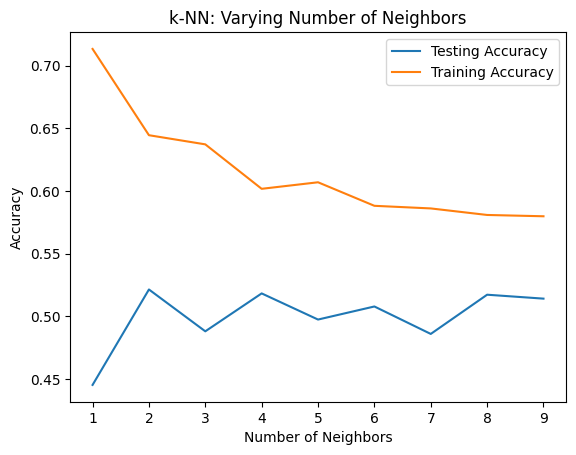

In [ ]:
# how can we figure out what the n_neighbors argument shouls be?
# we could iterate over the first 10 values it can take, afterwards the model is likely to become too simple

import numpy as np
import matplotlib.pyplot as plt

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

The graph above shows the number of clusters that yield highest training and testing accuracy. We can see that Training accuracy is highest when there is one cluster, while Testing error is highest at two clusters. Therefore, we can conclude that there aren't many similarities amongst the data in this set since most don't have a distinct neighbor. K nearest neighbor will not yield a viable model.

Decision Tree

In [ ]:
#Import libraries 

import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# Define a parameter grid with distributions of possible parameters to use
rs_param_grid = {
    "criterion": ["gini"],
    "max_depth": list((range(4, 10))),
    "min_samples_split": list((range(2, 5))),
    "min_samples_leaf": list((range(1, 5))),
    "ccp_alpha": [0, 0.001, 0.01, 0.1],
}

# Create a decision tree classifer object
clf2 = DecisionTreeClassifier(random_state=123)

# Instantiate RandomizedSearchCV() with clf and the parameter grid
clf_rs = RandomizedSearchCV(
    estimator=clf2,
    param_distributions=rs_param_grid,
    cv=3,  # Number of folds
    n_iter=20,  # Number of parameter candidate settings to sample
    verbose=3,  # The higher this is, the more messages are outputed
    random_state=42,
)

# Train the model on the training set
clf_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", clf_rs.best_params_)
print("Best accuracy found: ", clf_rs.best_score_)

We find that the optimal parameters are follows: 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5. Let's apply it to the Decision Tree to see if it improves the accuracy of the model. 



In [ ]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
params = {
    "criterion": "gini",  # Function to measure the quality of a split: 'Gini' or 'Entropy'
    "max_depth": 5,  # Max depth of the tree
    "min_samples_split": 3,  # Min number of samples required to split a node
    "min_samples_leaf": 1,  # Min number of samples required at a leaf node
    "ccp_alpha": 0.01,  # Cost complexity parameter for pruning
    "random_state": 123,
}

# Create a DecisionTreeClassifier object with the parameters above
clf = DecisionTreeClassifier(**params)

# Train the decision tree classifer on the train set
clf = clf.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5411887382690302


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The accuracy score is 54%, which means the model can classify each data point correctly using model_make and pressure_type into a violation_frequency only 54% percent fo the time. 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(50.722222222222214, 0.5, 'Actual')

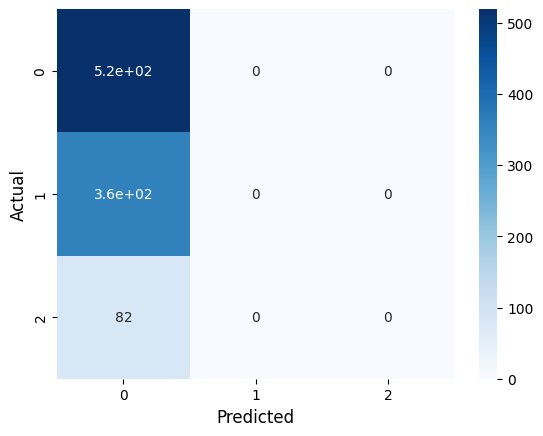

In [ ]:
#Confusion matrix on test set to see 
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)   

Note that 0 = single_violation, 1 = frequent_violation and 2 = persistant_violation.
The confusion matrix above displays that the predictive model is grouping all data points into single_violations. It is not picking up any frequent_violation or persistant_violation values, so it is not suitable to use a decision tree for this data. 

# Clustering

Given a set of boiler data, we will group the boilers into boiler sements to access which boilers cause the most HPD violations

In [ ]:
# Loading dataset from project into Google Drive
! gdown --id 1bFf4kwBULKVj75FLWTOrthYFSFl_PsZe

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bFf4kwBULKVj75FLWTOrthYFSFl_PsZe
To: /content/HPDwithBoilers.csv
100% 1.97M/1.97M [00:00<00:00, 161MB/s]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv("HPDwithBoilers.csv")
df.shape

(31970, 10)

In [ ]:
print(df.shape)
df.head()

(31970, 10)


,Unnamed: 0,bin,boro,story,class,violations_count,correct_make,pressure_type,defects_exist,report_type
0,0,1000794,MANHATTAN,6,C,1,TELEDYNE LAAR,Low Pressure,No,Initial
1,1,1000810,MANHATTAN,3,C,1,ROCKMILLS,Low Pressure,No,Initial
2,2,1001053,MANHATTAN,5,C,2,WEIL MCLAIN,Low Pressure,No,Initial
3,3,1001096,MANHATTAN,2,C,1,TELEDYNE,Low Pressure,No,Initial
4,4,1001136,MANHATTAN,2,C,1,ROCKMILLS,Low Pressure,No,Initial


In [ ]:
# Data Profiling: Need to make sure that none of the rows in the 
# dataframe are null
df.isnull().sum()

Unnamed: 0          0
bin                 0
boro                0
story               0
class               0
violations_count    0
correct_make        0
pressure_type       0
defects_exist       0
report_type         0
dtype: int64

# Initial visualizations of the data using dataframe

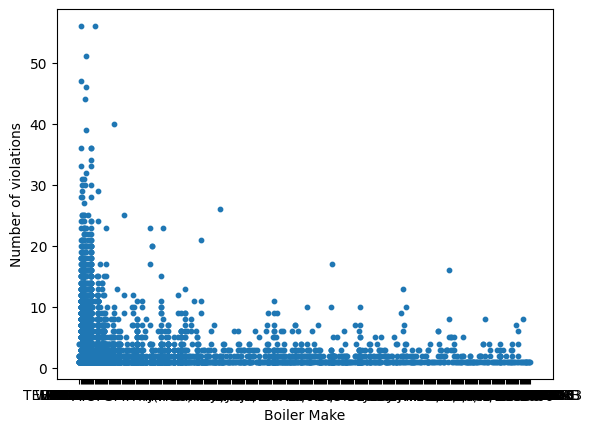

In [ ]:
# Compare age to spending score
plt.scatter(df["correct_make"], df["violations_count"], s=10)
plt.xlabel("Boiler Make")
plt.ylabel("Number of violations")
plt.show()

In [ ]:
# Create proportional sample of data to make the x axis more visible
proportionate_sample = df.groupby('correct_make', group_keys=False).apply(lambda x: x.sample(frac=0.00035))
print(len(proportionate_sample), "x", len(proportionate_sample.columns))
proportionate_sample.head()

10 x 10


,Unnamed: 0,bin,boro,story,class,violations_count,correct_make,pressure_type,defects_exist,report_type
28962,28962,3337145,BROOKLYN,2,C,1,BURNHAM,Low Pressure,Yes,Initial
27174,27174,3148733,BROOKLYN,6,C,1,FEDERAL,Low Pressure,No,Subsequent
31078,31078,4207126,QUEENS,3,C,13,FEDERAL,Low Pressure,No,Initial
7034,7034,1063313,MANHATTAN,5,C,1,FEDERAL,Low Pressure,No,Initial
25679,25679,3116160,BROOKLYN,2,C,1,HB SMITH,Low Pressure,No,Initial


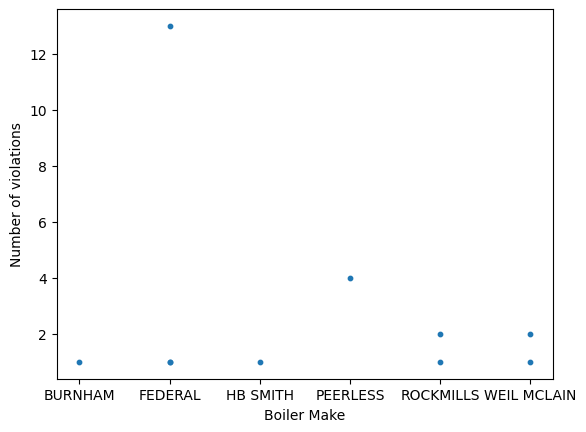

In [ ]:
# Compare correct boiler make to violations count in proportionate_sample
plt.scatter(proportionate_sample["correct_make"], proportionate_sample["violations_count"], s=10)
plt.xlabel("Boiler Make")
plt.ylabel("Number of violations")
plt.show()

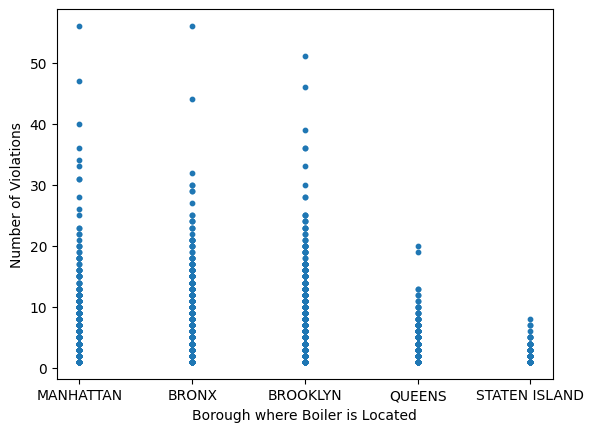

In [ ]:
# Compare Borough to Number of Violations
plt.scatter(df["boro"], df["violations_count"], s=10)
plt.xlabel("Borough where Boiler is Located")
plt.ylabel("Number of Violations")
plt.show()

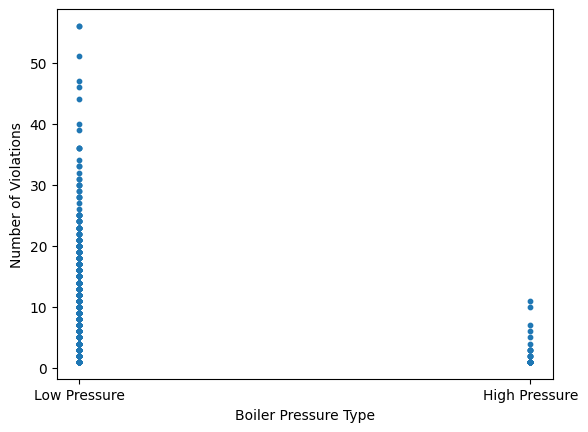

In [ ]:
# Compare pressure type to number of violations
plt.scatter(df["pressure_type"], df["violations_count"], s=10)
plt.xlabel("Boiler Pressure Type")
plt.ylabel("Number of Violations")
plt.show()

# Creation of the df2 dataframe

We will create another dataframe, df2, which will initially be a copy of df.

We will create columns to express the row values in df1 (which are strings) in terms of a integers/floats

In order to run scale variables/Kmeans classifer in SK Learn, this is a prerequisite before the model can be run

In [ ]:
# For now, let df2 just be a copy of df, which will have all the float columns to feed into the models
#df2 = df
# Note to self: DO NOT DO THIS!!!!, We will drop many rows from df in df2

df2 = df.copy()


In [ ]:
"""
Code generated by question asked to ChatGPT: 

'In Python Pandas, how do you make a new column in a dataframe by comparing 
values from another column, and assigning values in the new column "1" if the 
row value in the corresponding column is "MANHATTAN', "2" if the row value in 
the corresponding column is "BRONX", "3" if the row value of the corresponding 
column is "BROOKLYN", "4" if the row value of the corresponding column is 
"QUEENS", AND "5" if the row value of the corresponding column is "STATEN 
ISLAND"'

Link: https://chat.openai.com/c/06730cca-1478-46bb-9516-d5e775826721
"""
# import pandas as pd
import numpy as np

# data = {'Borough': ['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN ISLAND']}
# df = pd.DataFrame(data)

conditions = [
    (df2['boro'] == 'MANHATTAN'),
    (df2['boro'] == 'BRONX'),
    (df2['boro'] == 'BROOKLYN'),
    (df2['boro'] == 'QUEENS'),
    (df2['boro'] == 'STATEN ISLAND')
]

values = ['1', '2', '3', '4', '5']

# df2['boro_num'] = np.select(conditions, values, default=None)
boro_num = np.select(conditions, values, default=None)

df2.insert(2, 'boro_num', boro_num)

print(df2.shape)
df2.head()

(31970, 11)


,Unnamed: 0,bin,boro_num,boro,story,class,violations_count,correct_make,pressure_type,defects_exist,report_type
0,0,1000794,1,MANHATTAN,6,C,1,TELEDYNE LAAR,Low Pressure,No,Initial
1,1,1000810,1,MANHATTAN,3,C,1,ROCKMILLS,Low Pressure,No,Initial
2,2,1001053,1,MANHATTAN,5,C,2,WEIL MCLAIN,Low Pressure,No,Initial
3,3,1001096,1,MANHATTAN,2,C,1,TELEDYNE,Low Pressure,No,Initial
4,4,1001136,1,MANHATTAN,2,C,1,ROCKMILLS,Low Pressure,No,Initial


In [ ]:
"""
Question asked to ChatGPT: 
In Python Pandas, how do you make a new column in a dataframe by comparing 
values from another column class, and assigning values in the new column "2" if the 
row value in the corresponding column is "B",  and "3" if the row value of the 
corresponding column is "C"? There are no null values in the class column.

"""

df2.insert(5, 'class_num', df2['class'].apply(lambda x: 1 if x == 'Low Pressure' else 2))

print(df2.shape)
df2.head()


(31970, 12)


,Unnamed: 0,bin,boro_num,boro,story,class_num,class,violations_count,correct_make,pressure_type,defects_exist,report_type
0,0,1000794,1,MANHATTAN,6,2,C,1,TELEDYNE LAAR,Low Pressure,No,Initial
1,1,1000810,1,MANHATTAN,3,2,C,1,ROCKMILLS,Low Pressure,No,Initial
2,2,1001053,1,MANHATTAN,5,2,C,2,WEIL MCLAIN,Low Pressure,No,Initial
3,3,1001096,1,MANHATTAN,2,2,C,1,TELEDYNE,Low Pressure,No,Initial
4,4,1001136,1,MANHATTAN,2,2,C,1,ROCKMILLS,Low Pressure,No,Initial


In [ ]:
# Creating column called pressure_type_num which evaluates to "1" if the corresponding row
# value in df2[pressure_type] is "Low Pressure" and "2" if the corresponding row
# value in df2[pressure_type] is "High Pressure"
df2.insert(9, 'pressure_type_num', df2['pressure_type'].apply(lambda x: 1 if x == 'Low Pressure' else 2))

print(df2.shape)
df2.head()


31970 x 13


,Unnamed: 0,bin,boro_num,boro,story,class_num,class,violations_count,correct_make,pressure_type_num,pressure_type,defects_exist,report_type
0,0,1000794,1,MANHATTAN,6,2,C,1,TELEDYNE LAAR,1,Low Pressure,No,Initial
1,1,1000810,1,MANHATTAN,3,2,C,1,ROCKMILLS,1,Low Pressure,No,Initial
2,2,1001053,1,MANHATTAN,5,2,C,2,WEIL MCLAIN,1,Low Pressure,No,Initial
3,3,1001096,1,MANHATTAN,2,2,C,1,TELEDYNE,1,Low Pressure,No,Initial
4,4,1001136,1,MANHATTAN,2,2,C,1,ROCKMILLS,1,Low Pressure,No,Initial


In [ ]:
# Creating column called defects_exist_num which evaluates to "0" if the corresponding row
# value in df2[defects_exist] is "No" and "1" if the corresponding row
# value in df2[defects_exist] is "Yes"

df2['defects_exist_num'] = df2['defects_exist'].apply(lambda x: 1 if x == 'Yes' else 0)

print(df2.shape)
df2.insert(11, 'defects_exist_num', df2.pop('defects_exist_num'))
df2.head()


(31970, 14)


,Unnamed: 0,bin,boro_num,boro,story,class_num,class,violations_count,correct_make,pressure_type_num,pressure_type,defects_exist_num,defects_exist,report_type
0,0,1000794,1,MANHATTAN,6,2,C,1,TELEDYNE LAAR,1,Low Pressure,0,No,Initial
1,1,1000810,1,MANHATTAN,3,2,C,1,ROCKMILLS,1,Low Pressure,0,No,Initial
2,2,1001053,1,MANHATTAN,5,2,C,2,WEIL MCLAIN,1,Low Pressure,0,No,Initial
3,3,1001096,1,MANHATTAN,2,2,C,1,TELEDYNE,1,Low Pressure,0,No,Initial
4,4,1001136,1,MANHATTAN,2,2,C,1,ROCKMILLS,1,Low Pressure,0,No,Initial


In [ ]:
# Creating column called report_type_num which evaluates to "1" if the corresponding row
# value in df2[report_type] is "Initial" and "2" if the corresponding row
# value in df2[report_type] is "Subsequent"

df2.insert(13, 'report_type_num', df2['report_type'].apply(lambda x: 1 if x == 'Initial' else 2))

print(df2.shape)
df2.head()

(31970, 15)


,Unnamed: 0,bin,boro_num,boro,story,class_num,class,violations_count,correct_make,pressure_type_num,pressure_type,defects_exist_num,defects_exist,report_type_num,report_type
0,0,1000794,1,MANHATTAN,6,2,C,1,TELEDYNE LAAR,1,Low Pressure,0,No,1,Initial
1,1,1000810,1,MANHATTAN,3,2,C,1,ROCKMILLS,1,Low Pressure,0,No,1,Initial
2,2,1001053,1,MANHATTAN,5,2,C,2,WEIL MCLAIN,1,Low Pressure,0,No,1,Initial
3,3,1001096,1,MANHATTAN,2,2,C,1,TELEDYNE,1,Low Pressure,0,No,1,Initial
4,4,1001136,1,MANHATTAN,2,2,C,1,ROCKMILLS,1,Low Pressure,0,No,1,Initial


In [ ]:
make_list = []

for make in df2['correct_make']:
  if make not in make_list:
    make_list.append(make)

print(len(make_list))
print(make_list)



make_ref_dict = {}
count = 1

for make in make_list:
  make_ref_dict[make] = count
  count += 1

print(make_ref_dict)



419
['TELEDYNE LAAR', 'ROCKMILLS', 'WEIL MCLAIN', 'TELEDYNE', 'FEDERAL', 'SUPREME', 'PEERLESS', 'SLANTFIN', 'HYDROTHERM', 'BURNHAM', 'LAAR', 'HB SMITH', 'AO SMITH', 'VIESSMANN', 'KEWANEE', 'WORLD POWER', 'LOCHINVAR', 'BEST', 'DUNKIRK', 'PENNCO', 'HYDROTHERM KN', 'CROWN', 'TELEDYNE LARRS', 'RBI', 'US NATIONAL', 'SPENCER', 'PACIFIC', 'NATCO', 'PEERLESS-6-GD', 'CROTTY', 'TELEDYNE LAARS', 'TELEDYNE LARR', 'WILLIAMSON', 'BURNHMAM', 'GROTTY', 'FITZGIBBONS', 'BUDERUS', 'PORTMOR', 'RUUD', 'PLYMOUTH', 'RUDD', 'AMERICAN STANDARD', 'CLEAVER BROOKS', 'AM STD', 'BRYAN', 'CAMUS', 'INDUSTRIAL', 'US RAD', 'RHEEM', 'AMERICAN STD', 'UTICA', 'RAYPAK', 'AMER RAD', 'AERCO', 'THATCHER', 'GWA', 'PREELESS', 'ENERJET', 'FULTON', 'MOD CON', 'ATH', 'COLUMBIA', 'CLEAVER BROOK', 'WILLIAMSON GWA', 'A.O. SMITH (H-STAMP)', 'PATTERSON KELLEY', 'COLUMBIABOILER CO', 'NEW YORKER', 'FT SPENCER', 'UNILUX', 'PATTERSON KEL', 'FEDERAL FST-2', 'HYROTHERM', 'CLEAVERBROOKS', 'PATTERSON KELLY', 'AMERICSTD', 'EASCO', 'US RADIATOR'

In [ ]:
# Creating a new column 'mapped_value' based on the dictionary mapping
# df2['correct_make_id'] = df2['correct_make'].map(make_ref_dict)
correct_make_id = df2['correct_make'].map(make_ref_dict)

# Inserting the 'mapped_value' column at the 8th position
df2.insert(7, 'correct_make_id', correct_make_id)

print(df2.shape)
df2.head()


(31970, 16)


,Unnamed: 0,bin,boro_num,boro,story,class_num,class,correct_make_id,violations_count,correct_make,pressure_type_num,pressure_type,defects_exist_num,defects_exist,report_type_num,report_type
0,0,1000794,1,MANHATTAN,6,2,C,1,1,TELEDYNE LAAR,1,Low Pressure,0,No,1,Initial
1,1,1000810,1,MANHATTAN,3,2,C,2,1,ROCKMILLS,1,Low Pressure,0,No,1,Initial
2,2,1001053,1,MANHATTAN,5,2,C,3,2,WEIL MCLAIN,1,Low Pressure,0,No,1,Initial
3,3,1001096,1,MANHATTAN,2,2,C,4,1,TELEDYNE,1,Low Pressure,0,No,1,Initial
4,4,1001136,1,MANHATTAN,2,2,C,2,1,ROCKMILLS,1,Low Pressure,0,No,1,Initial


In [ ]:
# Dropping all the non-int/float columns in the dataframe
df2.drop(['boro', 'class', 'correct_make', 'pressure_type', 'defects_exist', 'report_type'], axis=1, inplace=True)

print(df2.shape)
df2

In [ ]:
print(df2.shape)
df2

(31970, 12)


,Unnamed: 0,bin,boro_num,story,class_num,correct_make_id,violations_count,correct_make,pressure_type_num,defects_exist_num,report_type_num,Clusters
0,0,1000794,1,6,2,1,1,TELEDYNE LAAR,1,0,1,0
1,1,1000810,1,3,2,2,1,ROCKMILLS,1,0,1,0
2,2,1001053,1,5,2,3,2,WEIL MCLAIN,1,0,1,0
3,3,1001096,1,2,2,4,1,TELEDYNE,1,0,1,0
4,4,1001136,1,2,2,2,1,ROCKMILLS,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31965,31965,5158679,5,3,2,9,1,HYDROTHERM,1,0,1,1
31966,31966,5158679,5,4,2,9,1,HYDROTHERM,1,0,1,1
31967,31967,5158679,5,8,2,9,1,HYDROTHERM,1,0,1,1
31968,31968,5164260,5,2,2,11,1,LAAR,1,0,1,1


In [ ]:
# Ensuring there are still no null values
df2.isnull().sum()


Unnamed: 0           0
bin                  0
boro_num             0
story                0
class_num            0
correct_make_id      0
violations_count     0
pressure_type_num    0
defects_exist_num    0
report_type_num      0
dtype: int64

Scale variables

In [ ]:
scaler = StandardScaler()
scaler.fit(df2)
scaled_data = scaler.transform(df2)

In [ ]:
type(scaled_data)

numpy.ndarray

Train K-means classifer

In [ ]:
# n_clusters default = 8
# n_init = # of times KMeans is run with different centroid seeds
KM = KMeans(n_init=10, random_state=42)
KM.fit(scaled_data)

KMeans(n_init=10, random_state=42)

In [ ]:
KM.cluster_centers_

Determining the optimal K-value

In [ ]:
# Create function to find the optimal K value
def find_optimal_k(df, maximum_K=12):
    clusters_centers = []
    k_values = []

    for k in range(1, maximum_K):
        KM = KMeans(n_clusters=k, n_init=10, random_state=42)
        KM.fit(df)

        clusters_centers.append(KM.inertia_)
        k_values.append(k)

    return clusters_centers, k_values

In [ ]:
# Create function to generate elbow plot
def generate_elbow_plot(clusters_centers, k_values):
    
    figure = plt.subplots(figsize = (12, 6))
    plt.plot(k_values, clusters_centers, 'o-', color = 'red')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Cluster Inertia")
    plt.title("Elbow Plot of KMeans")
    plt.show()

In [ ]:
# Execute function to find optimal K value
clusters_centers, k_values = find_optimal_k(scaled_data)

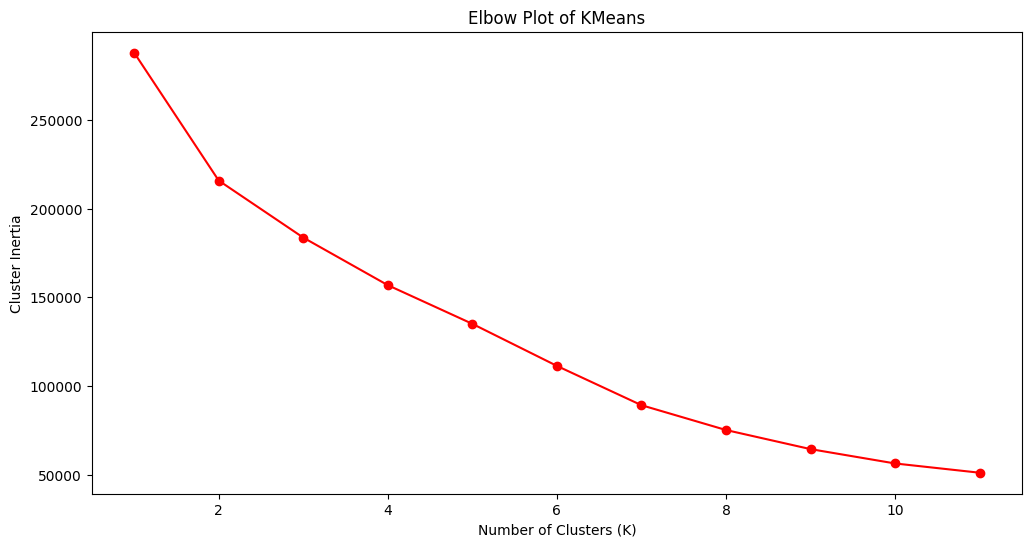

In [ ]:
# Display elbow plot
generate_elbow_plot(clusters_centers, k_values)

From the plot above, it seems that 6 is the optimal K value




Re-train K-means classifer with optimal K-value

In [ ]:
KM = KMeans(n_clusters=6, n_init=10, random_state=42)
KM.fit(scaled_data)

KMeans(n_clusters=6, n_init=10, random_state=42)

### Review re-training results

In [ ]:
# Add cluster # to original dataframe
df2["Clusters"] = KM.labels_
df2["Clusters"].unique()



array([1, 3, 5, 2, 4, 0], dtype=int32)

In [ ]:
print(df.shape)
df2.head()

(31970, 10)


,Unnamed: 0,bin,boro_num,story,class_num,correct_make_id,violations_count,correct_make,pressure_type_num,defects_exist_num,report_type_num,Clusters
0,0,1000794,1,6,2,1,1,TELEDYNE LAAR,1,0,1,1
1,1,1000810,1,3,2,2,1,ROCKMILLS,1,0,1,1
2,2,1001053,1,5,2,3,2,WEIL MCLAIN,1,0,1,1
3,3,1001096,1,2,2,4,1,TELEDYNE,1,0,1,1
4,4,1001136,1,2,2,2,1,ROCKMILLS,1,0,1,1


In [ ]:
print(df.columns)

# Reset the index of both dataframes
df.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

# Insert the 'correct_make' column from df into df2
df2.insert(7, 'correct_make', df['correct_make'])

# Verify the result
print(df2.shape)
df2.head()

Visualizing the clusters

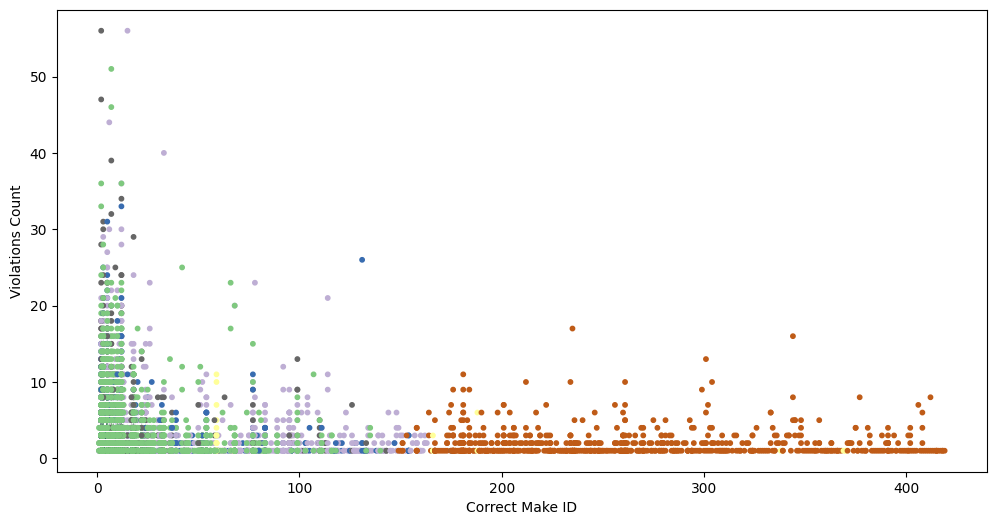

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(df2["correct_make_id"], df2["violations_count"], 
            c = df2["Clusters"], cmap='Accent', s=10)
plt.xlabel("Correct Make ID")
plt.ylabel("Violations Count")
plt.show()

In [ ]:
df2.to_csv("df2.csv")

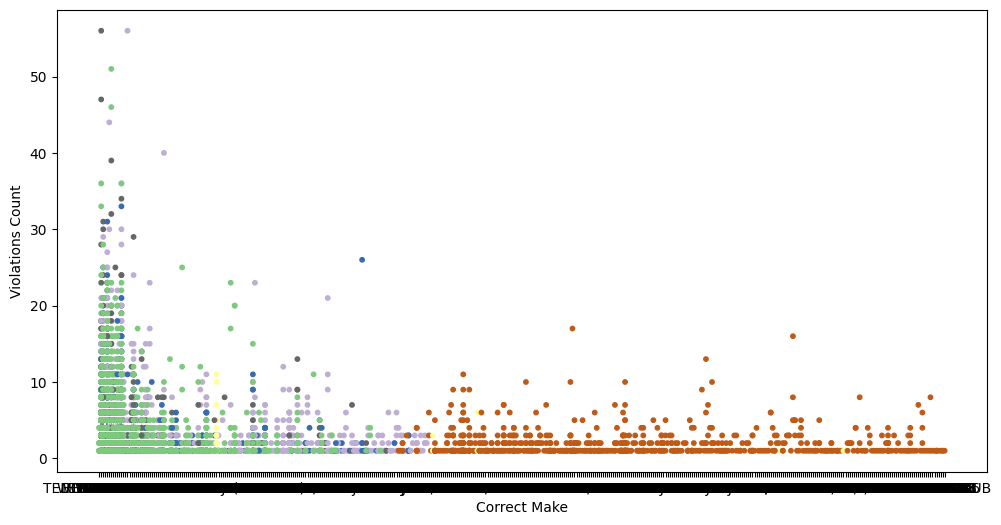

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(df2["correct_make"], df2["violations_count"], 
            c = df2["Clusters"], cmap='Accent', s=10)
plt.xlabel("Correct Make")
plt.ylabel("Violations Count")
plt.show()